# Astro Lab Book 2025

In [57]:
import astropy
import ccdproc
from astropy.nddata import CCDData
from astropy.time.time_helper.function_helpers import linspace
from ccdproc import ccd_process
import numpy as np
from pathlib import Path
import ccdproc as ccdp
from astropy import units as u
import matplotlib.pyplot as plt
import photutils.background as bg
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.utils import calc_total_error
from photutils.segmentation import SourceCatalog
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import MedianBackground
import os
import glob
import astroalign
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

### Combined Bias

In [2]:
raw_data = Path('data/bias')

calibrated_biases = glob.glob(str(raw_data / '*.fit*'))

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True
combined_bias.write(raw_data / 'combined_bias.fit', overwrite=True)

INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Dark Frame Cleaning

In [22]:
path_dark_raw = 'data/darks'
combined_bias = astropy.nddata.CCDData.read('data/bias/combined_bias.fit', unit='adu')

for file_path in glob.glob(os.path.join(path_dark_raw,'*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(file_path)
    ccd.write('data/darks/bias_subtracted_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[[ 955.   954.6  950.8 ...  976.8  987.4 1004.2]
 [ 951.8  953.6  951.6 ...  979.4  992.8  997.4]
 [ 952.8  953.6  957.6 ...  983.4  981.2  989. ]
 ...
 [ 964.   958.   958.8 ...  988.2 1003.2 1018.6]
 [ 959.8  957.8  963.4 ...  997.8 1001.6 1018.6]
 [ 967.6  957.6  960.8 ...  987.8 1002.6 1013.6]] adu


In [13]:
path_subtracted_dark_data = Path('data/darks')

dark_file_paths = glob.glob(str(path_subtracted_dark_data / 'bias_subtracted_*.dark.*.fits'))

combined_darks = ccdp.combine(dark_file_paths,
                             method='median',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_darks.meta['combined'] = True
combined_darks.write('data/darks/combined_darks.fit', overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 23 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning B-Filter Flats

In [25]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

combined_bias = ccdp.CCDData.read('data/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/flat_B/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/flat_B/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
4.261372911930075 adu


In [32]:
calibrated_flats = glob.glob('data/flat_B/*.fit')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/flat_B/combined_flats_B.fits', overwrite = True)

['data/flat_B\\combined_flats_B.fit']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000203564953D0>>
Traceback (most recent call last):
  File "C:\Users\alpha\PycharmProjects\JupyterProject\.venv1\Lib\site-packages\ipykernel\ipkernel.py", line 812, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alpha\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

### Cleaning the R Filter

In [4]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

combined_bias = ccdp.CCDData.read('data/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/flat_R/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/flat_R/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [7]:
calibrated_flats = glob.glob('data/flat_R/*.fits')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/flat_R/combined_flats_R.fits', overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning the R band Science Images

In [33]:
combined_dark = ccdp.CCDData.read('data/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/flat_R/combined_flats_R.fits', unit='adu')
print(combined_flat)
cleaned_science_path = Path('data/science_R')

i = 36
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


[[0.93776151 0.92525077 0.92578427 ... 0.91589084 0.89803776 0.05013559]
 [0.94007327 0.93862275 0.93671111 ... 0.9140623  0.9074273  0.05586547]
 [0.93321216 0.94519542 0.94365425 ... 0.91514226 0.9044326  0.05638898]
 ...
 [0.95690537 0.95300715 0.95094661 ... 0.93945292 0.91475504 0.05529003]
 [0.95613864 0.9524027  0.9488018  ... 0.93998262 0.92795337 0.0548105 ]
 [0.95065897 0.94152379 0.94814179 ... 0.93407178 0.92419765 0.05256037]] adu


### Cleaning the B band Science Images

In [13]:
combined_dark = ccdp.CCDData.read('data/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/flat_B/combined_flats_B.fit', unit='adu')
cleaned_science_path = Path('data/science_B')

i = 31
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


### Identifying sources

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


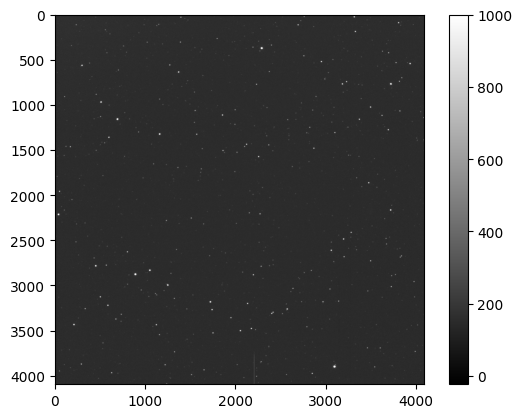

In [46]:
img = ccdp.CCDData.read('data/science_B/31.fits', unit='adu')
plt.imshow(img, vmin = -23, vmax = 1000,cmap='gray')
plt.colorbar()

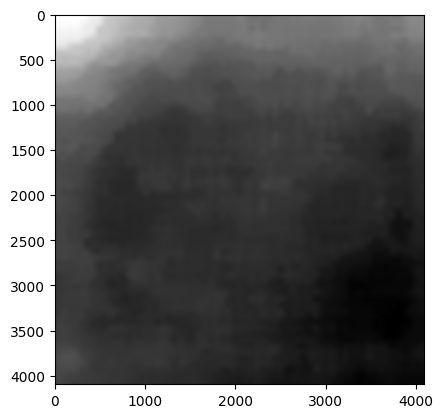

In [47]:
background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

plt.imshow(np.asarray(background.background), cmap='gray')
plt.show()

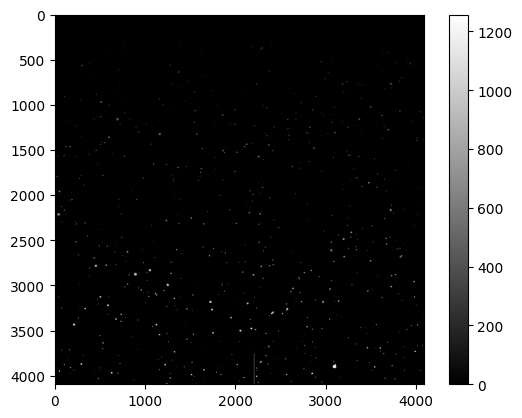

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 1257
labels: [   1    2    3    4    5 ... 1253 1254 1255 1256 1257]


In [48]:
threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3,3)
convolved_data = convolve(img, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold, npixels=5)
plt.imshow(segment_map, cmap='gray')
plt.colorbar()
plt.show()

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 1271
labels: [   1    2    3    4    5 ... 1267 1268 1269 1270 1271]


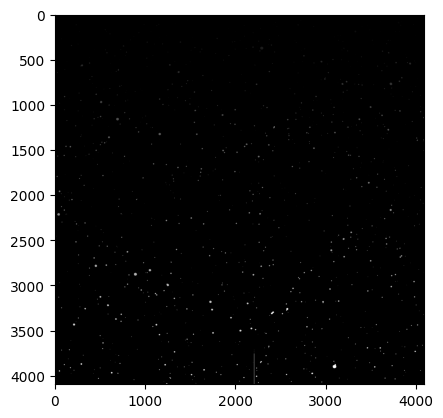

In [49]:
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels = 25, nlevels = 32, contrast = 0.001,
                               progress_bar = True)

plt.imshow(segm_deblend, cmap='gray')
print(segm_deblend)

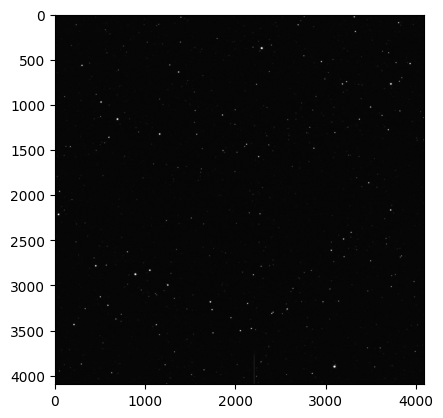

In [50]:
subtracted_background = img - background.background
plt.imshow(subtracted_background.data, cmap = 'gray', vmin = -23, vmax = 1000)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


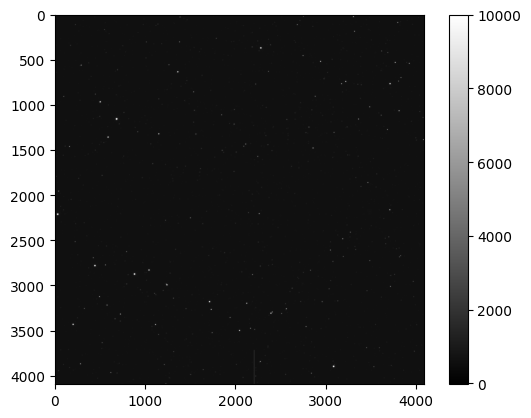

In [39]:
img = ccdp.CCDData.read('data/new-image.fits', unit='adu')
plt.imshow(img, vmin = -23, vmax = 10000,cmap='gray')
plt.colorbar()

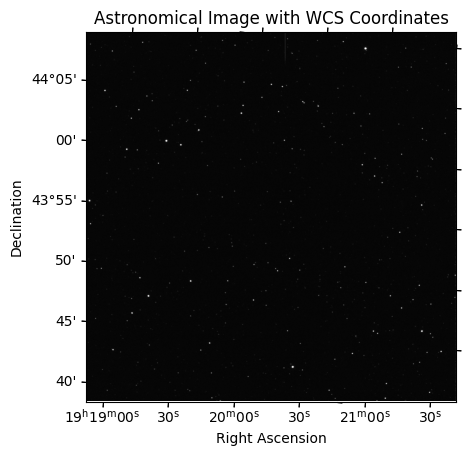

In [62]:
#image_file = 'data/science_R/36.fits'
wcs_file = 'data/wcs.fits'

#image_data = fits.getdata(image_file, ext=0)

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)

ax.imshow(subtracted_background.data, origin='lower', cmap='gray', vmin = -23, vmax = 1000)

#ax.coords.grid(True, color='white', ls='solid')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.title('Astronomical Image with WCS Coordinates')
plt.show()